In [2]:
from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName('Datacamp Pyspark Tutorial').config('spark.memory.offHeap.enabled','true')\
#         .config('spark.memory.offHeap.size','10g').getOrCreate()

spark = SparkSession.builder.appName('Datacamp Pyspark Tutorial').getOrCreate()

In [3]:
df = spark.read.csv('datacamp_ecommerce.csv',header=True,escape='\'')

In [4]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [5]:
df.show(3,0)

+---------+---------+----------------------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |
+---------+---------+----------------------------------+--------+------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6       |12/1/10 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN               |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER    |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|
+---------+---------+----------------------------------+--------+------------+---------+----------+--------------+
only showing top 3 rows



In [6]:
df.count()

541909

In [7]:
df.select('Country').distinct().count() 

38

In [8]:
df.select('CustomerID').distinct().count() 

4373

## RENAME COLUMNS

In [9]:
df = (df.withColumnRenamed('Quantity','QTY').withColumnRenamed('UnitPrice', 'PRICE'))
df.show(5,0)

+---------+---------+-----------------------------------+---+------------+-----+----------+--------------+
|InvoiceNo|StockCode|Description                        |QTY|InvoiceDate |PRICE|CustomerID|Country       |
+---------+---------+-----------------------------------+---+------------+-----+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6  |12/1/10 8:26|2.55 |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6  |12/1/10 8:26|3.39 |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8  |12/1/10 8:26|2.75 |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6  |12/1/10 8:26|3.39 |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6  |12/1/10 8:26|3.39 |17850     |United Kingdom|
+---------+---------+-----------------------------------+---+------------+-----+----------+--------------+
only showing top 5 rows



## convert column names to lower case

In [10]:
for col in df.columns:
    df = df.withColumnRenamed(col, col.lower())
df.show(3,0)

+---------+---------+----------------------------------+---+------------+-----+----------+--------------+
|invoiceno|stockcode|description                       |qty|invoicedate |price|customerid|country       |
+---------+---------+----------------------------------+---+------------+-----+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6  |12/1/10 8:26|2.55 |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN               |6  |12/1/10 8:26|3.39 |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER    |8  |12/1/10 8:26|2.75 |17850     |United Kingdom|
+---------+---------+----------------------------------+---+------------+-----+----------+--------------+
only showing top 3 rows



In [11]:
df.select('country','invoiceno').show(3,0)

+--------------+---------+
|country       |invoiceno|
+--------------+---------+
|United Kingdom|536365   |
|United Kingdom|536365   |
|United Kingdom|536365   |
+--------------+---------+
only showing top 3 rows



#### Get shape of df

In [12]:
(df.count(), len(df.columns))

(541909, 8)

## Processing date column

In [13]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [14]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("invoicedate", 'yy/MM/dd HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2012-12-10 16:21:00|
+-------------------+



In [15]:
df = df.withColumn("year",year('date'))
df2 = df.where(df.year < 10)
df2.select('CustomerID','year').show(5,0)

+----------+----+
|CustomerID|year|
+----------+----+
|13313     |1   |
|13313     |1   |
|13313     |1   |
|13313     |1   |
|13313     |1   |
+----------+----+
only showing top 5 rows



Years below 2010 are truncated eg 1 meaning 2001 
We are adding 2000 years (24000 months) to nomalize the date column 

In [16]:
import pyspark.sql.functions as F 

# create new column with processed date
df = df.withColumn(
    'final_date',
    F.when((F.col("year") < 10) , F.add_months(df['date'], 24000))\
    .otherwise(df['date'])
)

# drop original date column
df = df.drop(col("date")) 
df = (df.withColumnRenamed('final_date','date'))
df.printSchema()

root
 |-- invoiceno: string (nullable = true)
 |-- stockcode: string (nullable = true)
 |-- description: string (nullable = true)
 |-- qty: string (nullable = true)
 |-- invoicedate: string (nullable = true)
 |-- price: string (nullable = true)
 |-- customerid: string (nullable = true)
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- date: timestamp (nullable = true)



In [17]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2001-04-11 00:00:00|
+-------------------+



## Processing price
Column has negative values. We replace them with their absolute values

In [18]:
df.select('price').describe().show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|           541909|
|   mean|4.611113626089702|
| stddev|96.75985306117958|
|    min|        -11062.06|
|    max|            99.96|
+-------+-----------------+



In [19]:
df = df.withColumn('price',F.abs(df.price))
df.select('price').describe().show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|           541909|
|   mean|4.692766154466288|
| stddev| 96.7559273518238|
|    min|              0.0|
|    max|          38970.0|
+-------+-----------------+



In [20]:
df.groupBy('country').agg(countDistinct('customerid').alias('country_count')).show(3,0)

+---------+-------------+
|country  |country_count|
+---------+-------------+
|Sweden   |8            |
|Singapore|1            |
|Germany  |95           |
+---------+-------------+
only showing top 3 rows



In [21]:
df.groupBy('country').agg(countDistinct('customerid').alias('country_count')).orderBy(desc('country_count')).show(5,0)

#df.groupBy('country').agg(countDistinct('customerid').alias('country_count')).orderBy(desc('country_county')).show()
    

+--------------+-------------+
|country       |country_count|
+--------------+-------------+
|United Kingdom|3950         |
|Germany       |95           |
|France        |87           |
|Spain         |31           |
|Belgium       |25           |
+--------------+-------------+
only showing top 5 rows



In [22]:
df.select('invoicedate').show(5,0)

+------------+
|invoicedate |
+------------+
|12/1/10 8:26|
|12/1/10 8:26|
|12/1/10 8:26|
|12/1/10 8:26|
|12/1/10 8:26|
+------------+
only showing top 5 rows



### Get the most recent order
### convert date column into datetime and use min/max

In [23]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2001-04-11 00:00:00|
+-------------------+



In [24]:
df = df.withColumn('year', year('date').alias("year"))
df.printSchema()

root
 |-- invoiceno: string (nullable = true)
 |-- stockcode: string (nullable = true)
 |-- description: string (nullable = true)
 |-- qty: string (nullable = true)
 |-- invoicedate: string (nullable = true)
 |-- price: double (nullable = true)
 |-- customerid: string (nullable = true)
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- date: timestamp (nullable = true)



In [25]:
df1 = df.where(df.price<='0')
df1.count()

2515

In [26]:
df.describe("year").show()

+-------+------------------+
|summary|              year|
+-------+------------------+
|  count|            232959|
|   mean|2008.0056490627105|
| stddev| 3.566655812906784|
|    min|              2001|
|    max|              2012|
+-------+------------------+



In [27]:
df.select('year').distinct().show()

+----+
|year|
+----+
|null|
|2012|
|2001|
|2003|
|2004|
|2002|
|2006|
|2005|
|2007|
|2008|
|2009|
|2010|
|2011|
+----+



In [28]:
df.printSchema()

root
 |-- invoiceno: string (nullable = true)
 |-- stockcode: string (nullable = true)
 |-- description: string (nullable = true)
 |-- qty: string (nullable = true)
 |-- invoicedate: string (nullable = true)
 |-- price: double (nullable = true)
 |-- customerid: string (nullable = true)
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- date: timestamp (nullable = true)



## Prepare data for ML
### USE recency, frequency, and monetary value (RFM).

In [29]:
#  Recency: How recently has each customer made a purchase?
# Frequency: How often have they bought something?
# Monetary Value: How much money do they spend on average when making purchases?

## Assign recency value to customer. subtract latest date for customer purchase from earliest date

In [30]:
# create a column "from_date" and assign it a constant value of min date
df = df.withColumn("from_date", lit("01/4/11 00:00"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))
#df.show(5,0)

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date")\
    .cast("long") - col('from_date').cast("long"))

In [31]:
df2.select("from_date","recency","customerid").show(5,0)

+-------------------+---------+----------+
|from_date          |recency  |customerid|
+-------------------+---------+----------+
|2001-04-11 00:00:00|339236760|17850     |
|2001-04-11 00:00:00|339236760|17850     |
|2001-04-11 00:00:00|339236760|17850     |
|2001-04-11 00:00:00|339236760|17850     |
|2001-04-11 00:00:00|339236760|17850     |
+-------------------+---------+----------+
only showing top 5 rows



### RECENCY SHOULD NOT HAVE A NEGATIVE VALUE

In [32]:
df2.select('recency').describe().show()

+-------+--------------------+
|summary|             recency|
+-------+--------------------+
|  count|              232959|
|   mean|2.2777186048806873E8|
| stddev|1.1208771477985704E8|
|    min|                   0|
|    max|           368209260|
+-------+--------------------+



In [33]:
#df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')
df2.groupBy("customerid").agg(max("recency")).alias("recency").show(5,0)

+----------+------------+
|customerid|max(recency)|
+----------+------------+
|16250     |339242340   |
|15574     |341941560   |
|15555     |360348780   |
|15271     |360337620   |
|17714     |null        |
+----------+------------+
only showing top 5 rows



In [34]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')
df2.show(5,0)

+---------+---------+---------+----------------------------------+---+------------+-----+----------+--------------+----+-------------------+-------------------+
|recency  |invoiceno|stockcode|description                       |qty|invoicedate |price|customerid|country       |year|date               |from_date          |
+---------+---------+---------+----------------------------------+---+------------+-----+----------+--------------+----+-------------------+-------------------+
|339237300|536369   |21756    |BATH BUILDING BLOCK WORD          |3  |12/1/10 8:35|5.95 |13047     |United Kingdom|2012|2012-01-10 08:35:00|2001-04-11 00:00:00|
|339238800|536371   |22086    |PAPER CHAIN KIT 50'S CHRISTMAS    |80 |12/1/10 9:00|2.55 |13748     |United Kingdom|2012|2012-01-10 09:00:00|2001-04-11 00:00:00|
|339240720|536375   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6  |12/1/10 9:32|2.55 |17850     |United Kingdom|2012|2012-01-10 09:32:00|2001-04-11 00:00:00|
|339240720|536375   |71053    |WHI

In [35]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- invoiceno: string (nullable = true)
 |-- stockcode: string (nullable = true)
 |-- description: string (nullable = true)
 |-- qty: string (nullable = true)
 |-- invoicedate: string (nullable = true)
 |-- price: double (nullable = true)
 |-- customerid: string (nullable = true)
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



### FREQUENCY

In [36]:
df_freq = df2.groupBy("customerid").agg(count("invoicedate").alias('frequency'))
#df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))
df_freq.show(5,0)

+----------+---------+
|customerid|frequency|
+----------+---------+
|16250     |14       |
|15574     |121      |
|15271     |81       |
|15555     |153      |
|17757     |215      |
+----------+---------+
only showing top 5 rows



### Combine the new df with the previous one

In [37]:
df3 = df2.join(df_freq,on='customerid',how='inner')
df3.printSchema()

root
 |-- customerid: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- invoiceno: string (nullable = true)
 |-- stockcode: string (nullable = true)
 |-- description: string (nullable = true)
 |-- qty: string (nullable = true)
 |-- invoicedate: string (nullable = true)
 |-- price: double (nullable = true)
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



In [38]:
df3 = df3.withColumn("amount", col('qty') * col("price"))
df3.select('customerid',"amount").show(5,0)

+----------+------------------+
|customerid|amount            |
+----------+------------------+
|13047     |17.85             |
|13748     |204.0             |
|17850     |15.299999999999999|
|17850     |20.34             |
|17850     |22.0              |
+----------+------------------+
only showing top 5 rows



In [39]:
df3.printSchema()

root
 |-- customerid: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- invoiceno: string (nullable = true)
 |-- stockcode: string (nullable = true)
 |-- description: string (nullable = true)
 |-- qty: string (nullable = true)
 |-- invoicedate: string (nullable = true)
 |-- price: double (nullable = true)
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)
 |-- amount: double (nullable = true)



## Get the total amount spent per customer

In [40]:
val_df = df3.groupBy('customerid').agg(sum("amount").alias("customer_total")).orderBy("customer_total", ascending=False)
val_df.show(5,0)

+----------+------------------+
|customerid|customer_total    |
+----------+------------------+
|14646     |69054.59          |
|18102     |59069.880000000005|
|14156     |32919.69000000001 |
|14911     |30877.55          |
|17511     |29603.910000000003|
+----------+------------------+
only showing top 5 rows



In [41]:
final_df = val_df.join(df3,on='customerid',how='inner')

In [42]:
final_df = final_df.select(['recency','frequency','customer_total','customerid']).distinct()
final_df.show(5,0)

+---------+---------+------------------+----------+
|recency  |frequency|customer_total    |customerid|
+---------+---------+------------------+----------+
|339242340|14       |226.14            |16250     |
|341941560|121      |375.65            |15574     |
|360337620|81       |1044.99           |15271     |
|360348780|153      |1177.3199999999997|15555     |
|5270400  |81       |1044.99           |15271     |
+---------+---------+------------------+----------+
only showing top 5 rows



In [43]:
final_df.printSchema()

root
 |-- recency: long (nullable = true)
 |-- frequency: long (nullable = false)
 |-- customer_total: double (nullable = true)
 |-- customerid: string (nullable = true)



## STANDARDIZATION

In [44]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','customer_total'
], outputCol='features')

# combines input columns into a list under one column "features"
assembled_data=assemble.transform(final_df)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [45]:
data_scale_output.select('features','standardized').show(3,0)

+--------------------------+------------------------------------------------------------+
|features                  |standardized                                                |
+--------------------------+------------------------------------------------------------+
|[3.3924234E8,14.0,226.14] |[3.0362792093010005,0.06603798473309043,0.03996852911303932]|
|[3.4194156E8,121.0,375.65]|[3.060437707816632,0.5707568680502815,0.06639328717304864]  |
|[3.6033762E8,81.0,1044.99]|[3.2250857128712305,0.38207691167002317,0.1846940534086626] |
+--------------------------+------------------------------------------------------------+
only showing top 3 rows



## Building the ML clustering model

In [46]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette',\
             distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

In [47]:
cost[2:]

array([15463.94938238,  8605.9012332 ,  7231.6826219 ,  5964.6683155 ,
        5015.75146873,  4274.19638644,  4274.59349938,  3076.89511872])

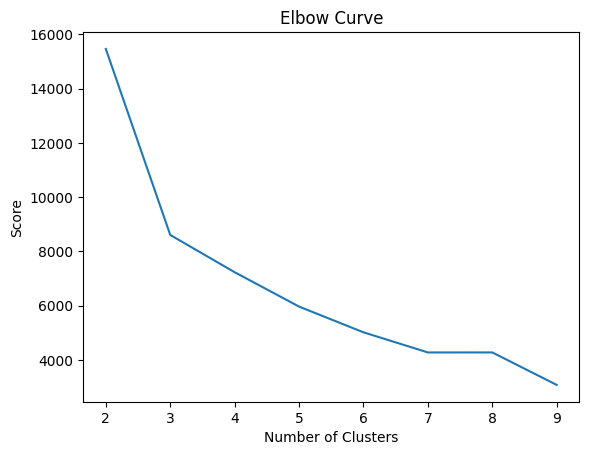

In [48]:
import pandas as pd
#import pylab as pl
import matplotlib.pyplot as plt
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
plt.plot(df_cost.cluster, df_cost.cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

From the plot above, we can see that there is an inflection point that looks like an elbow at five. Due to this, we will proceed to build the K-Means algorithm with four clusters:

In [49]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [50]:
preds=KMeans_fit.transform(data_scale_output)

preds.printSchema()

root
 |-- recency: long (nullable = true)
 |-- frequency: long (nullable = false)
 |-- customer_total: double (nullable = true)
 |-- customerid: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- standardized: vector (nullable = true)
 |-- prediction: integer (nullable = false)



In [51]:
preds.select(['recency','frequency','customer_total','prediction']).show(5,0)

+---------+---------+------------------+----------+
|recency  |frequency|customer_total    |prediction|
+---------+---------+------------------+----------+
|339242340|14       |226.14            |1         |
|341941560|121      |375.65            |1         |
|360337620|81       |1044.99           |1         |
|360348780|153      |1177.3199999999997|1         |
|5270400  |81       |1044.99           |0         |
+---------+---------+------------------+----------+
only showing top 5 rows



## Cluster analysis

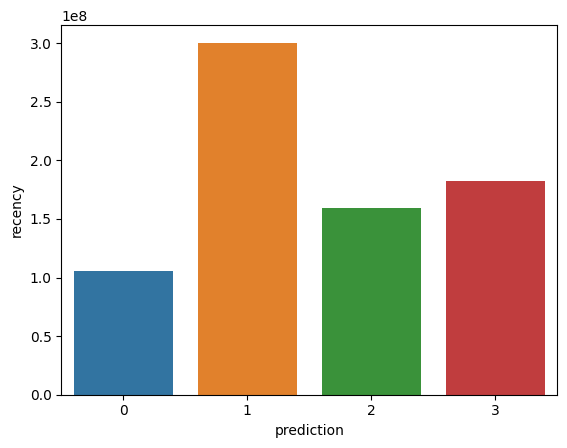

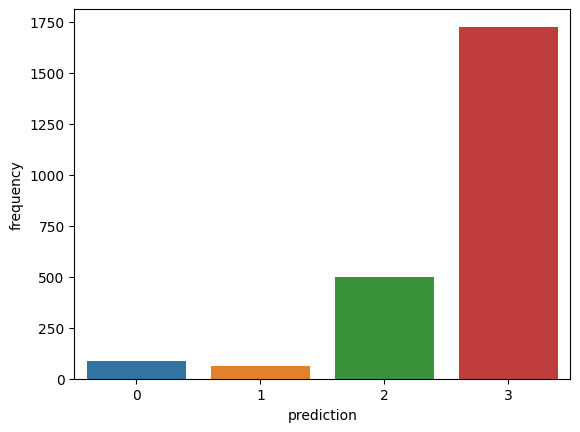

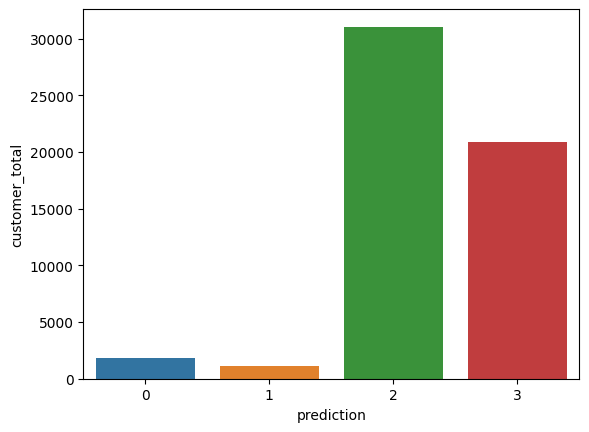

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','customer_total','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

# sns.barplot(x="prediction", y="recency", data=df_viz)
# plt.show()
list1 = ['recency','frequency','customer_total']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

In [54]:
avg_df

,prediction,recency,frequency,customer_total
0,0,1.059445e+08,87.925166,1785.054334
1,1,3.003588e+08,64.318384,1159.337621
2,2,1.592854e+08,500.905172,31049.518190
3,3,1.825614e+08,1726.140845,20923.417887


Here is an overview of characteristics displayed by customers in each cluster:

Cluster 0: Customers in this segment display low recency, frequency, and monetary value. They rarely shop on the platform and are low potential customers who are likely to stop doing business with the ecommerce company. 
Cluster 1: Users in this cluster display high recency but haven’t been seen spending much on the platform. They also don’t visit the site often. This indicates that they might be newer customers who have just started doing business with the company.
Cluster 2: Customers in this segment display medium recency and frequency and spend a lot of money on the platform. This indicates that they tend to buy high-value items or make bulk purchases.
Cluster 3: The final segment comprises users who display high recency and make frequent purchases on the platform. However, they don’t spend much on the platform, which might mean that they tend to select cheaper items in each purchase.